In [15]:
# Import stuff
from torchvision import transforms, datasets
import os
from PIL import Image
import numpy as np
import platform
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader, random_split
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [16]:
# For running in colab
def in_colab() -> bool:
    try:
        import google.colab
        return True
    except Exception:
        return False

In [17]:
# Select device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"{torch.cuda.get_device_name(0)}")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device.type}\n")
# Print the gpu model

NVIDIA A100-SXM4-40GB
Using device: cuda



## Prepare Dataset

In [18]:
# Find images that are the wrong shape
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
dirs = []

if in_colab():
    from google.colab import drive
    !mkdir models
    drive.mount('/content/drive')
    dirs = ['/content/drive/MyDrive/2025-2026/Semester 1/MTH 4320/data/seg_test/seg_test/' + category for category in categories]
    dirs.extend(['/content/drive/MyDrive/2025-2026/Semester 1/MTH 4320/data/seg_train/seg_train/' + category for category in categories])
else:
    dirs = ['data/seg_test/seg_test/' + category for category in categories]
    dirs.extend(['data/seg_train/seg_train/' + category for category in categories])

counter = 0
for dir in dirs:
    for image in os.listdir(dir):
        image_path = os.path.join(dir, image)
        if image_path.endswith(('.jpg', 'jpeg', '.png')):
            img = Image.open(image_path)
            if img.size != (150, 150):
                os.remove(image_path)
                counter += 1
print(f"Images with wrong shape: {counter}") # originally 55
# 4 minutes on google colab

mkdir: cannot create directory ‘models’: File exists
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Images with wrong shape: 0


In [19]:
# Load data
if in_colab():
    dataset = datasets.ImageFolder(root="/content/drive/MyDrive/2025-2026/Semester 1/MTH 4320/data/seg_train/seg_train/", transform=transforms.ToTensor())
    test_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/2025-2026/Semester 1/MTH 4320/data/seg_test/seg_test/", transform=transforms.ToTensor())
else:
    dataset = datasets.ImageFolder(root="data/seg_train/seg_train", transform=transforms.ToTensor())
    test_dataset = datasets.ImageFolder(root="data/seg_test/seg_test", transform=transforms.ToTensor())

print(f"Classes: {dataset.classes}")

# Split data
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Data loaders
batch_size = 128
print(f"Batch size: {batch_size}")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train size: 11188
Val size: 2798
Test size: 2993
Batch size: 128


## Functions

In [20]:
# Calculate accuracy from logits
def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)  # choose class with highest predicted score
    return (preds == y).float().mean().item()  # fraction of correct predictions

def train(name, model, optimizer, epochs, criterion, history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}):
    # Early stopping settings
    patience = 10          # epochs to wait after last improvement
    min_delta = 0.0        # minimum change in val_loss to qualify as improvement
    best_val = 10e20       # track best validation loss
    best_epoch = -1
    patience_ctr = 0
    best_ckpt_path = "best.pt"

    train_start_time = time.time()

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        # Training
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            running_correct += (logits.argmax(1) == y).sum().item()
            total += x.size(0)

        train_loss = running_loss / total
        train_acc  = running_correct / total

        # Validation
        model.eval()
        val_running_loss, val_running_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)
                val_running_loss += loss.item() * x.size(0)
                val_running_correct += (logits.argmax(1) == y).sum().item()
                val_total += x.size(0)

        val_loss = val_running_loss / val_total
        val_acc  = val_running_correct / val_total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch:02d} | "
            f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
            f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
            f"time: {epoch_time:.2f}s")

        # Early stopping check (monitor val_loss)
        if val_loss < best_val - min_delta:
            best_val = val_loss
            best_epoch = epoch
            patience_ctr = 0
            # Save best checkpoint so far
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "history": history,
                "best_val_loss": best_val
            }, best_ckpt_path)
            print(f"  -> New best val_loss {best_val:.4f} at epoch {epoch}. Saved to {best_ckpt_path}.")
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch} "
                    f"(no improvement for {patience} epochs). Best epoch: {best_epoch}.")
                break

    # Total training time
    total_time = time.time() - train_start_time
    print(f"\nTotal training time: {total_time:.2f}s")
    print(f"Best epoch: {best_epoch} | Best val_loss: {best_val:.4f}")

    # Restore best model before final save (in case we stopped after it)
    ckpt = torch.load(best_ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])

    # Save final artifact (model + history)
    final_path = f"models/{name}.pth"
    if in_colab():
        final_path = f"/content/models/{name}.pth"
    torch.save({
        "model_state": model.state_dict(),
        "history": history,
        "best_epoch": best_epoch,
        "best_val_loss": best_val
    }, final_path)
    print(f"Final model saved to '{final_path}'")

def display_results(path, model):
    # Loss and accuracy graph
    # Load the trained model from file
    #model = MLP(128*128).to(device)  # initialize model structure
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    history = checkpoint["history"]

    model.eval()  # set to evaluation mode

    # Prepare x-axis for plots
    epochs = range(1, len(history["train_loss"]) + 1)

    # Create figure and first axis (loss)
    fig, ax1 = plt.subplots()

    color_loss = "tab:blue"
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color=color_loss)
    ax1.plot(epochs, history["train_loss"], label="Train Loss", color=color_loss, linestyle="-")
    ax1.plot(epochs, history["val_loss"], label="Val Loss", color=color_loss, linestyle="--")
    ax1.tick_params(axis="y", labelcolor=color_loss)

    # Second y-axis for accuracy
    ax2 = ax1.twinx()
    color_acc = "tab:orange"
    ax2.set_ylabel("Accuracy", color=color_acc)
    ax2.plot(epochs, history["train_acc"], label="Train Acc", color=color_acc, linestyle="-")
    ax2.plot(epochs, history["val_acc"], label="Val Acc", color=color_acc, linestyle="--")
    ax2.tick_params(axis="y", labelcolor=color_acc)

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

    plt.title("Loss and Accuracy over Epochs")
    fig.tight_layout()
    plt.show()




    # Confusion matrix
    # Variables to track accuracy
    test_correct, test_total = 0, 0

    # Lists to store predictions and true labels for the confusion matrix
    all_preds, all_trues = [], []

    # Disable gradient computation for faster evaluation
    with torch.no_grad():
        # Loop through the test set in batches
        for x, y in test_loader:
            # Move inputs to the computation device (CPU/GPU/MPS)
            x = x.to(device)

            # Forward pass to get raw model outputs (logits)
            logits = model(x)

            # Get predicted class indices (highest logit per sample)
            preds = logits.argmax(1).cpu().numpy()

            # Store predictions and ground truth labels for later
            all_preds.append(preds)
            all_trues.append(y.numpy())

            # Update accuracy counters
            test_correct += (preds == y.numpy()).sum()
            test_total   += y.size(0)

    # Compute overall test accuracy
    test_acc = test_correct / test_total
    print(f"Test accuracy: {test_acc:.4f}")

    # Flatten predictions and true labels into 1D arrays
    y_true = np.concatenate(all_trues).ravel()
    y_pred = np.concatenate(all_preds).ravel()

    # Dynamically detect classes from both true and predicted
    class_labels = np.unique(np.concatenate((y_true, y_pred)))
    print(f"Detected {len(class_labels)} classes: {class_labels}")

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)

    # Plot annotated confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(
        cm,
        annot=True,              # annotate all cells
        fmt="d",                 # integer format
        cbar=True,
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.title("Confusion Matrix (Test)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

## 1st Model

Epoch 01 | train: loss=1.7088, acc=0.3149 | val: loss=1.4755, acc=0.4603 | time: 40.67s
  -> New best val_loss 1.4755 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=1.3752, acc=0.4776 | val: loss=1.2477, acc=0.5007 | time: 41.12s
  -> New best val_loss 1.2477 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=1.1547, acc=0.5501 | val: loss=1.1809, acc=0.5518 | time: 41.53s
  -> New best val_loss 1.1809 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=1.0729, acc=0.5753 | val: loss=1.1153, acc=0.5761 | time: 41.59s
  -> New best val_loss 1.1153 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=1.0269, acc=0.5986 | val: loss=1.1023, acc=0.5751 | time: 40.63s
  -> New best val_loss 1.1023 at epoch 5. Saved to best.pt.
Epoch 06 | train: loss=1.0035, acc=0.6082 | val: loss=1.0459, acc=0.6090 | time: 41.04s
  -> New best val_loss 1.0459 at epoch 6. Saved to best.pt.
Epoch 07 | train: loss=0.9799, acc=0.6181 | val: loss=1.0227, acc=0.5994 | time: 40.94s
  -> New best val_loss 1

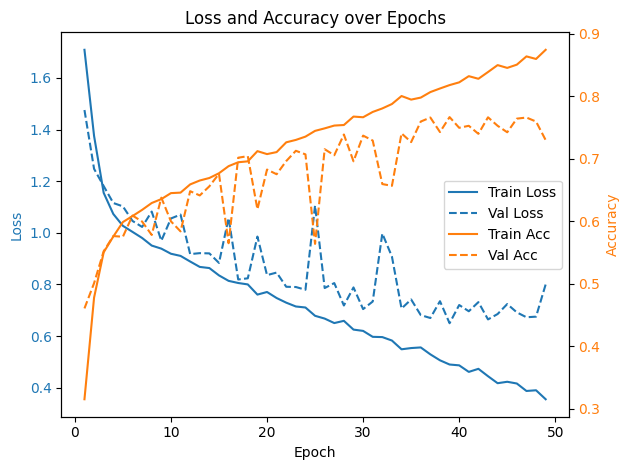

Test accuracy: 0.7658
Detected 6 classes: [0 1 2 3 4 5]


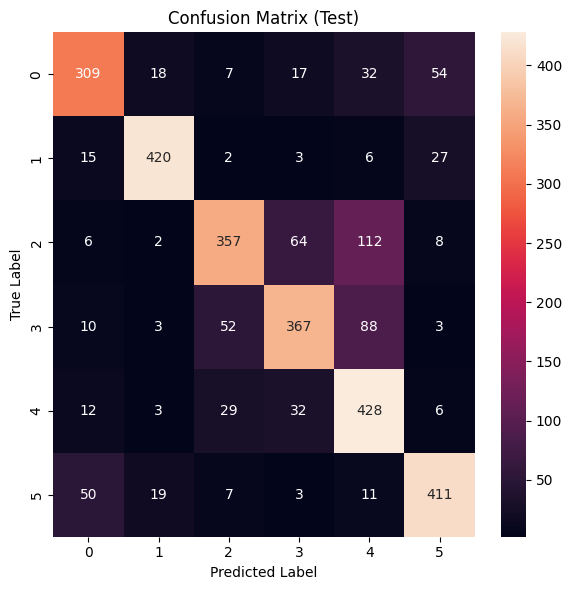

In [21]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, x):
        return self.net(x)

name = "CNN1"
model = CNN1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 100
criterion = nn.CrossEntropyLoss()

train(name, model, optimizer, epochs, criterion)
display_results("models/CNN1.pth", model)

## 2nd Model

Epoch 01 | train: loss=75.6502, acc=0.1734 | val: loss=1.7922, acc=0.1758 | time: 41.47s
  -> New best val_loss 1.7922 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=1.7916, acc=0.1757 | val: loss=1.7911, acc=0.1780 | time: 42.16s
  -> New best val_loss 1.7911 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=1.7914, acc=0.1762 | val: loss=1.7907, acc=0.1780 | time: 42.07s
  -> New best val_loss 1.7907 at epoch 3. Saved to best.pt.
Epoch 04 | train: loss=1.7911, acc=0.1749 | val: loss=1.7915, acc=0.1780 | time: 42.83s
Epoch 05 | train: loss=1.7914, acc=0.1785 | val: loss=1.7917, acc=0.1780 | time: 40.55s
Epoch 06 | train: loss=1.7915, acc=0.1753 | val: loss=1.7912, acc=0.1780 | time: 40.76s
Epoch 07 | train: loss=1.7912, acc=0.1774 | val: loss=1.7915, acc=0.1619 | time: 40.58s
Epoch 08 | train: loss=1.7913, acc=0.1777 | val: loss=1.7911, acc=0.1780 | time: 40.51s
Epoch 09 | train: loss=1.7913, acc=0.1762 | val: loss=1.7916, acc=0.1619 | time: 40.68s
Epoch 10 | train: loss=1.79

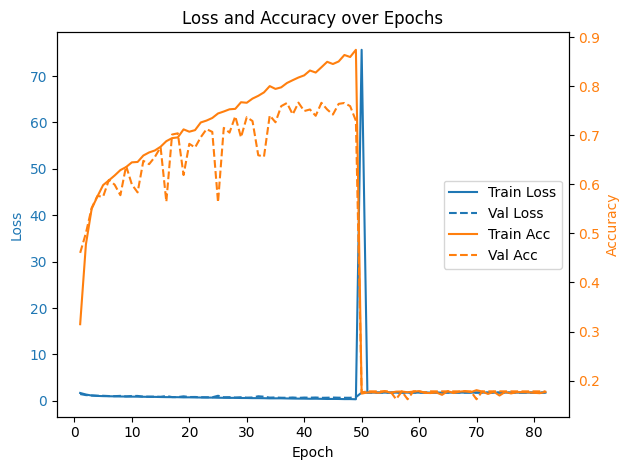

Test accuracy: 0.1747
Detected 6 classes: [0 1 2 3 4 5]


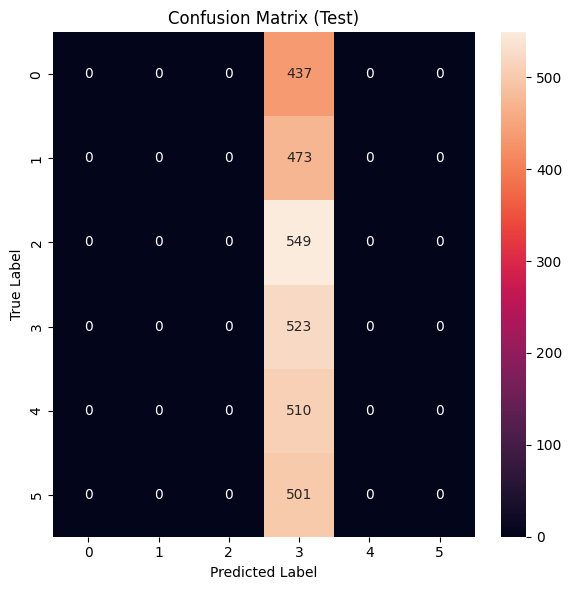

In [22]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, x):
        return self.net(x)

name = "CNN2"
model = CNN2().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 100
criterion = nn.CrossEntropyLoss()

train(name, model, optimizer, epochs, criterion)
display_results("models/CNN2.pth", model)
# 9 min on A100 with batch size = 128, val loss = 1.7938, val acc = 0.1673

## 3rd Model

Epoch 01 | train: loss=1.3295, acc=0.5135 | val: loss=0.9850, acc=0.6108 | time: 41.28s
  -> New best val_loss 0.9850 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.8399, acc=0.6771 | val: loss=0.8161, acc=0.6926 | time: 42.18s
  -> New best val_loss 0.8161 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.7167, acc=0.7321 | val: loss=0.8813, acc=0.6959 | time: 42.79s
Epoch 04 | train: loss=0.6461, acc=0.7622 | val: loss=0.6739, acc=0.7448 | time: 41.74s
  -> New best val_loss 0.6739 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=0.5609, acc=0.7934 | val: loss=0.6790, acc=0.7588 | time: 42.03s
Epoch 06 | train: loss=0.4861, acc=0.8263 | val: loss=0.6151, acc=0.7873 | time: 40.99s
  -> New best val_loss 0.6151 at epoch 6. Saved to best.pt.
Epoch 07 | train: loss=0.4281, acc=0.8478 | val: loss=0.6398, acc=0.7881 | time: 42.47s
Epoch 08 | train: loss=0.3646, acc=0.8682 | val: loss=0.7082, acc=0.7734 | time: 40.66s
Epoch 09 | train: loss=0.2740, acc=0.9031 | val: loss=0.

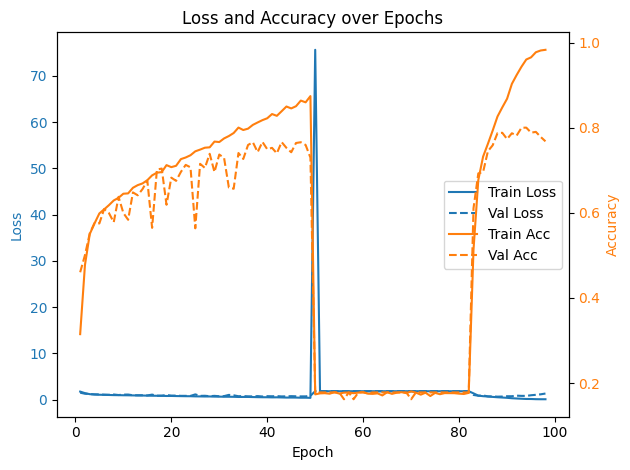

Test accuracy: 0.8099
Detected 6 classes: [0 1 2 3 4 5]


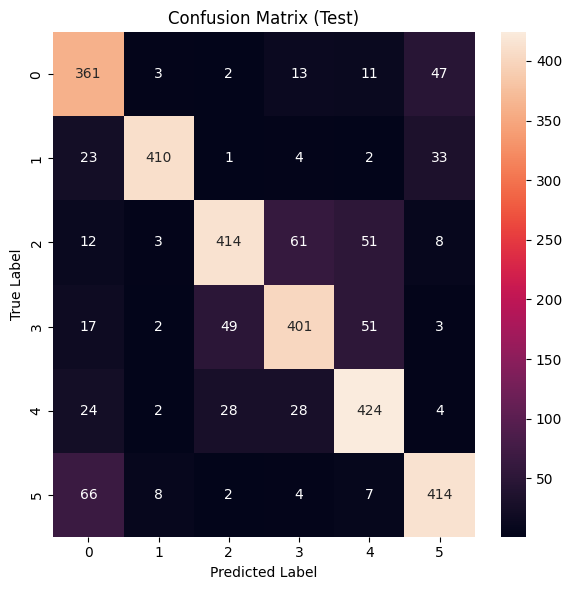

In [23]:
class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, x):
        return self.net(x)

name = "CNN3"
model = CNN3().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()

train(name, model, optimizer, epochs, criterion)
display_results("models/CNN3.pth", model)

## 4th model

Epoch 01 | train: loss=1.1603, acc=0.5483 | val: loss=0.9534, acc=0.6512 | time: 40.02s
  -> New best val_loss 0.9534 at epoch 1. Saved to best.pt.
Epoch 02 | train: loss=0.7703, acc=0.7057 | val: loss=0.7195, acc=0.7366 | time: 41.58s
  -> New best val_loss 0.7195 at epoch 2. Saved to best.pt.
Epoch 03 | train: loss=0.6191, acc=0.7679 | val: loss=0.7263, acc=0.7409 | time: 41.55s
Epoch 04 | train: loss=0.5108, acc=0.8134 | val: loss=0.5913, acc=0.7920 | time: 39.23s
  -> New best val_loss 0.5913 at epoch 4. Saved to best.pt.
Epoch 05 | train: loss=0.3999, acc=0.8532 | val: loss=0.6652, acc=0.7723 | time: 41.29s
Epoch 06 | train: loss=0.3100, acc=0.8871 | val: loss=0.5490, acc=0.8259 | time: 39.52s
  -> New best val_loss 0.5490 at epoch 6. Saved to best.pt.
Epoch 07 | train: loss=0.2381, acc=0.9163 | val: loss=0.5949, acc=0.8152 | time: 40.85s
Epoch 08 | train: loss=0.1345, acc=0.9558 | val: loss=0.7468, acc=0.8074 | time: 39.65s
Epoch 09 | train: loss=0.0851, acc=0.9731 | val: loss=0.

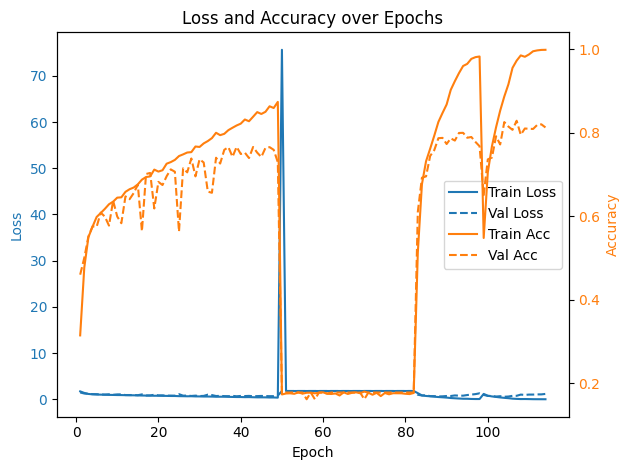

Test accuracy: 0.8202
Detected 6 classes: [0 1 2 3 4 5]


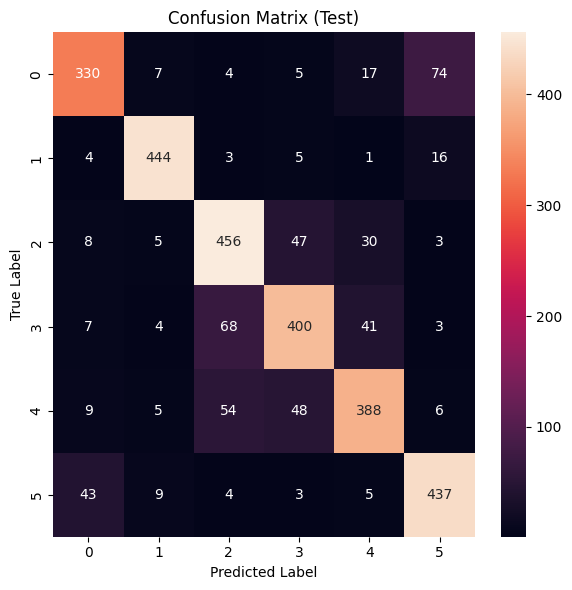

In [24]:
class CNN4(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, x):
        return self.net(x)

name = "CNN4"
model = CNN4().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
criterion = nn.CrossEntropyLoss()

train(name, model, optimizer, epochs, criterion)
display_results("models/CNN4.pth", model)